### Predicting Molecular Properties Using SMILES

"SMILES" is an acronym for Simplified Molecular Input Line System and they use short ASCII strings to describe the structure of chemical species. Extracting molecular properties from SMILES strings is a common task in cheminformatics. In this project, we demonstrate a simplified workflow and showcase some widely used toolkits in cheminformatics.

The overall goal is to use the SMILES string to predict the boiling point of a given molecule, and the workflow is shown below.
        
        Obtain Data  -->  Clean Data  -->  Explore Data  -->  Build Model  -->  Evaluate and Interpret Model
        
 #### We start by importing useful packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import shap
import rdkit, rdkit.Chem, rdkit.Chem.Draw, rdkit.Chem.PandasTools, rdkit.RDLogger
from mordred import Calculator, descriptors  # Generate desciptors from SMILES
import cirpy  # CAS No. to SMILES
import warnings

warnings.filterwarnings("ignore")
rdkit.RDLogger.DisableLog("rdApp.*")
%matplotlib inline

#### Next step is to obtain data

We want a dataset that has both SMILES strings and boiling points. The closest dataset I can easily get is the CRC Handbook, which contains boiling points and CAS numbers, but it does not have SMILES strings. We need to use the "cirpy" toolbox to convert the CAS numbers to SMILES strings. The dataScraper() funtion scrapes the raw data and the dataCleaner() function removes unwanted data and performs the CAS number-to-SMILES string conversion. The pre-processed data is then saved in a .csv file for easy access.


In [2]:
# Scraping data from CRC handbook


def dataScraper():
    """
    This function scrapes data from the CRC handbook,
    the raw data is returned in a DataFrame.
    """
    data = pd.read_html(
        "https://hbcp.chemnetbase.com/faces/documents/03_01/03_01_0001.xhtml"
    )[5]
    for i in range(2, 545):
        address = f"https://hbcp.chemnetbase.com/faces/documents/03_01/03_01_0{str(i).zfill(3)}.xhtml"
        cur_data = pd.read_html(address)[3]
        data = pd.concat([data, cur_data], ignore_index=True)
    return data


def dataCleaner(raw_data):
    """
    This function cleans the data and remove entries without
    boiling point. The corresponding SMILES strings are also
    identified using the CAS No.

    input: raw data (DataFrame)
    output: clean data (DataFrame)
    """

    def bpCleaner(boiling_point):
        try:
            return float(boiling_point)
        except:
            return np.nan

    def cas2smiles(cas_no):
        try:
            return cirpy.resolve(cas_no, "smiles")
        except:
            return "NA"

    raw_data.drop(raw_data.columns[[0, 1, 2, 3, 6, 11, 14, 15]], axis=1, inplace=True)
    raw_data = raw_data[~raw_data["Solubility"].astype(str).str.startswith("Continued")]
    raw_data.columns = [
        "MolecularFormular",
        "CAS No.",
        "MolecularWeight",
        "PhysicalForm",
        "MeltingPoint",
        "BoilingPoint",
        "Density",
        "RefractiveIndex",
        "Solubility",
    ]
    raw_data["BoilingPoint"] = raw_data["BoilingPoint"].apply(lambda x: bpCleaner(x))
    raw_data = raw_data[raw_data["BoilingPoint"].notna()]
    raw_data["SMILES"] = raw_data["CAS No."].apply(lambda x: cas2smiles(x))
    raw_data = raw_data[raw_data["SMILES"] != "NA"]
    return raw_data


# raw_data = dataScraper()
# data = dataCleaner(raw_data)
## data.to_csv('CRC_withSMILES.csv') #file saved to csv for easy access

#### Next step is to clean data

We remove unwanted information from the raw data and prepare the dataset for feature generation. 

In [3]:
# Further cleaning data

raw_data = pd.read_csv("CRC_withSMILES.csv")
raw_data = raw_data[raw_data["SMILES"].notna()]
raw_data = raw_data.reset_index(drop=True)
raw_data = raw_data.drop(index=[289, 460])
raw_data = raw_data.reset_index(drop=True)
raw_data = raw_data[["MolecularFormular", "BoilingPoint", "SMILES"]]
rdkit.Chem.PandasTools.AddMoleculeColumnToFrame(raw_data, smilesCol="SMILES")

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2120 entries, 0 to 2119
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MolecularFormular  2120 non-null   object 
 1   BoilingPoint       2120 non-null   float64
 2   SMILES             2120 non-null   object 
 3   ROMol              2120 non-null   object 
dtypes: float64(1), object(3)
memory usage: 66.4+ KB


,MolecularFormular,BoilingPoint,SMILES,ROMol
0,C20H30O2,439.5,CC(C)C1=CC2=CC[C@@H]3[C@](C)(CCC[C@@]3(C)C(O)=...,
1,C12H8,280.0,c1cc2cccc3C=Cc(c1)c23,

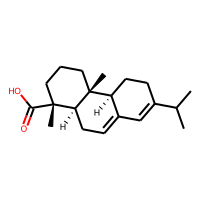
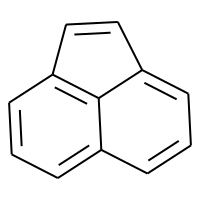

In [5]:
raw_data.head(2)

#### Next step is to check and explore data

We want to check if the boiling point has a skewed distribution and to check if the SMILES strings are correct. So we plot a histgram using the boiling and we visualize the molucules with their SMILES strings.

Text(0, 0.5, 'Counts')

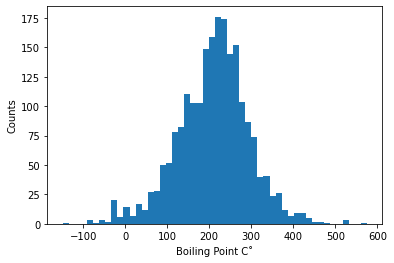

In [6]:
_ = plt.hist(raw_data.BoilingPoint, bins=50)
plt.xlabel("Boiling Point C˚")
plt.ylabel("Counts")
# plt.hist

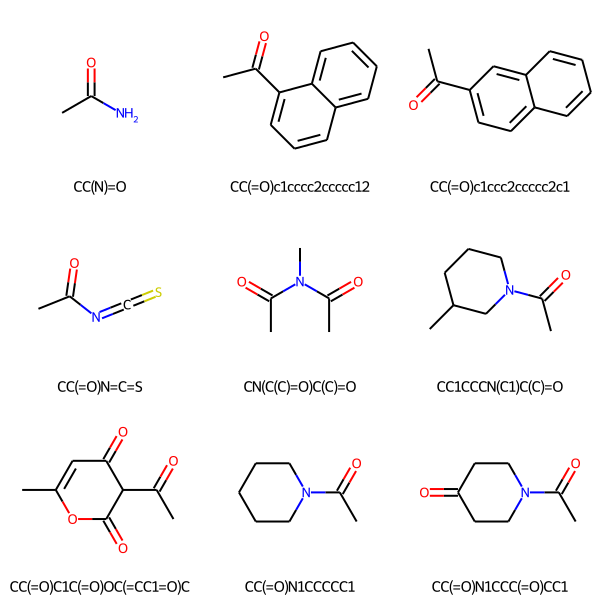

In [7]:
rdkit.Chem.PandasTools.FrameToGridImage(
    raw_data.iloc[np.r_[2:5, 7:11, 13:15]], legendsCol="SMILES", molsPerRow=3
)

We then generate quantitative features to describe the molecules using their SMIELS strings, 'mordred' is a package does just that. The calculated features are saved in a .csv file for easy access. Only features with top correlation scores are used for demonstration.

In [8]:
# calc = Calculator(descriptors, ignore_3D=True)
# df_desc = calc.pandas(raw_data['ROMol'])
# df_desc.to_csv('calculated_descriptors.csv',sep=',')

In [9]:
df_desc = pd.read_csv("calculated_descriptors.csv", sep=",")
df_desc["target_v"] = raw_data["BoilingPoint"]
df_desc.corr()["target_v"].abs()[df_desc.corr()["target_v"].abs() > 0.7].sort_values(
    ascending=False
)

target_v    1.000000
piPC1       0.781443
SRW02       0.760324
VAdjMat     0.758568
TpiPC10     0.755053
piPC2       0.731417
TMWC10      0.726607
MWC02       0.725344
nC          0.722417
nBondsO     0.720705
MWC01       0.720705
MWC03       0.715440
piPC6       0.715367
piPC3       0.713429
Xp-5d       0.712580
SRW04       0.711830
Xp-1d       0.708841
SMR         0.706854
piPC4       0.706416
Xp-4d       0.705572
piPC5       0.703179
ABC         0.701123
piPC7       0.700309
Name: target_v, dtype: float64

#### Next step is to build the model
Several descriptors are chosen to predict the target value. Two different tree ensembles are demonstrated here, the RandomForest regressor using bagging method and the XGBoost Regressor using gradient boosting method.

In [10]:
X = df_desc[
    [
        "piPC1",
        "SRW02",
        "VAdjMat",
        "TpiPC10",
        "nBondsO",
        "nC",
        "MWC02",
        "TMWC10",
        "piPC2",
    ]
]
y = df_desc["target_v"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

boosting = xgb.XGBRegressor(reg_alpha=1.5)
bagging = RandomForestRegressor()
boosting.fit(X_train, y_train)
bagging.fit(X_train, y_train)
print(f"MSE of XGBRegressor is {mean_squared_error(boosting.predict(X_test),y_test)}")
print(
    f"MSE of RandomForestRegressor is {mean_squared_error(bagging.predict(X_test),y_test)}"
)

MSE of XGBRegressor is 2171.6954725947576
MSE of RandomForestRegressor is 2200.4849805275217


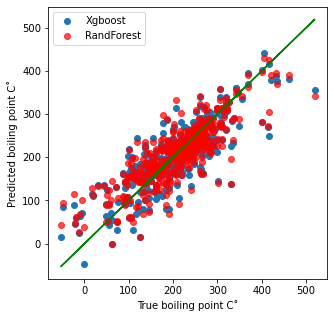

In [11]:
plt.figure(figsize=(5, 5))
plt.plot(y_test, boosting.predict(X_test), "o")
plt.plot(y_test, bagging.predict(X_test), "ro", alpha=0.7)

plt.plot(y_test, y_test, "g-")
plt.xlabel("True boiling point C˚")
plt.ylabel("Predicted boiling point C˚")
plt.legend(["Xgboost", "RandForest"])

#### Next step is to interpret the model

From the parity plot, we can see that both algorithms can make reasonable predictions of boiling points. The dataset is very small, so XGBoost does not significantly outperform RandomForest. to understand the importance of the features in the model, we can use a package called "SHAP".

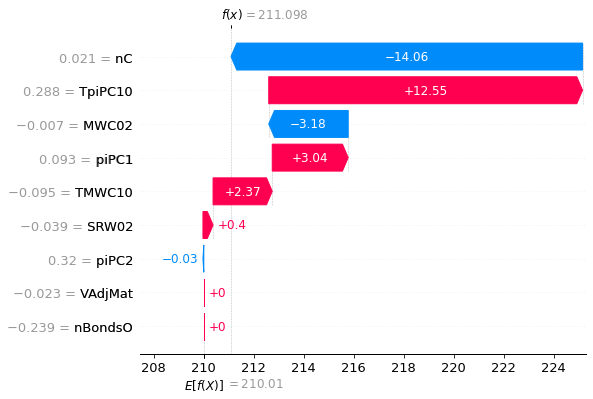

In [12]:
explainer = shap.Explainer(boosting, feature_names=X.columns)
shap_values = explainer(X_train)

# visualize the first prediction's explanation
shap.plots.waterfall(
    shap_values[5],
)

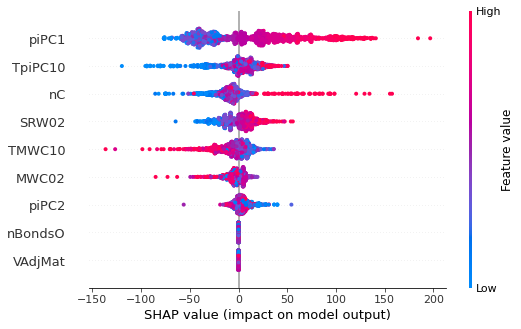

In [13]:
shap.plots.beeswarm(shap_values)

### Conclusion

This project uses a smiple example to demonstrate how to predict molecular properties using SMILES strings, and here is some take home message:
        
        XGBoost and RandomForest have similar performance when dataset is small.
        SHAP can help interpret feature importance of a model.
        Features that have high correlation with target value may not be important due to Multicollinearity.
        

### Reference
        
        https://www.kaggle.com/code/rmonge/predicting-molecule-properties-based-on-its-smiles/notebook
        https://xinhaoli74.github.io/posts/2020/04/RDKit-Cheatsheet/